# Using simple Deep Neural Network to predict Count of total rental bikes

### Cleanning Data/Preprocessing
During EDA, there weren't any Na's in the data set, but there were categorical data that should be converted to dummies. The 'cleanningData' function will get dummies for the categorical features. The categorical features are actually type 'int64' in this data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# to classify features
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification

# split data, need to redo this part with stratified split!!
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# DNN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Daily Data Set

In [23]:
dailyData = pd.read_csv('C:/Users/Jenny/Desktop/UOP-MSDS/2020Spring/ANLT_210_SoftwareMethods/Bikeshare/Data/daily.csv')

In [24]:
dailyData.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [25]:
dailyData.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Same as in the EDA phase, we will remove features that aren't needed and repeative.

In [26]:
dailyData2 = dailyData.drop([  ], axis = 1)

In [2]:
def cleaningData(df):
    # taking out 'cnt', we don't want to get dummies for 'cnt'
    dataset = df.drop(['cnt'], axis = 1)
    
    # making a list of possible categorical features
    possibleCate = []
    for i in range(len(dataset.columns)):
        if dataset.dtypes[i] == 'int64':
            possibleCate.append(dataset.columns[i])
            
    #get dummies for categorical features
    for cat in possibleCate:
        dataset = pd.concat([dataset, pd.get_dummies(dataset[cat], prefix = cat, dummy_na = False)], axis = 1)
        dataset = dataset.drop(cat, axis = 1)
    
    # adding 'cnt' back into the data set
    dataset = pd.concat([dataset, df['cnt']], axis = 1)
    
    return dataset
    #print(possibleCate)

In [27]:
dailyCate = cleaningData(dailyData2)

In [28]:
dailyCate.head()

,temp,atemp,hum,windspeed,season_1,season_2,season_3,season_4,yr_0,yr_1,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,cnt
0,0.344167,0.363625,0.805833,0.160446,1,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,985
1,0.363478,0.353739,0.696087,0.248539,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,801
2,0.196364,0.189405,0.437273,0.248309,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,1349
3,0.200000,0.212122,0.590435,0.160296,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,1562
4,0.226957,0.229270,0.436957,0.186900,1,0,0,0,1,0,...,1,0,0,0,0,1,1,0,0,1600


In [29]:
dailyCate.shape

(731, 37)

### Feature selection

Using sklearn's ExtraTreesClassifier to determine which features to extract.

In [3]:
def featureSelect(dataset, n):
    # splitting X (features) and y (output) to be used in ExtraTreesClassifier
    X = dataset.drop(['cnt'], axis = 1)
    y = dataset['cnt']

    # bulid the model
    extra_tree_forest = ExtraTreesClassifier(n_estimators = 10,
                                             criterion = 'gini')

    # train the model
    extra_tree_forest.fit(X, y)

    # compute importance of each feature
    feature_importance = extra_tree_forest.feature_importances_

    # Normalizing the individual importances 
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                            extra_tree_forest.estimators_], 
                                            axis = 0)

    # sort orderFeat from greatest to least
    orderFeat = np.argsort(-feature_importance_normalized)

    # top n features
    featUsed = []
    for i in range(n):
        featUsed.append(X.columns[orderFeat[i]])
        
    xFeat = pd.DataFrame(dataset[featUsed])

    return xFeat, y

In [30]:
xfeat, y =  featureSelect(dailyCate, 10)

In [31]:
xfeat.head()

,atemp,hum,mnth_3,windspeed,weekday_4,temp,yr_1,weekday_5,weathersit_2,weekday_2
0,0.363625,0.805833,0,0.160446,0,0.344167,0,0,1,0
1,0.353739,0.696087,0,0.248539,0,0.363478,0,0,1,0
2,0.189405,0.437273,0,0.248309,0,0.196364,0,0,0,0
3,0.212122,0.590435,0,0.160296,0,0.200000,0,0,0,1
4,0.229270,0.436957,0,0.186900,0,0.226957,0,0,0,0


### Split and normalize the data
The data set is normalized using StandardScaler from sklearns. The split will be 80% for train and 20% for test.

In [32]:
df = pd.concat([xfeat, y], axis = 1)

In [33]:
df.shape

(731, 11)

In [34]:
# normalize
sc = MinMaxScaler(feature_range=(0, 1))
df2 = pd.DataFrame(sc.fit_transform(df))

In [35]:
df2.columns = df.columns

In [36]:
df2.head()

,atemp,hum,mnth_3,windspeed,weekday_4,temp,yr_1,weekday_5,weathersit_2,weekday_2,cnt
0,0.373517,0.828620,0.0,0.284606,0.0,0.355170,0.0,0.0,1.0,0.0,0.110792
1,0.360541,0.715771,0.0,0.466215,0.0,0.379232,0.0,0.0,1.0,0.0,0.089623
2,0.144830,0.449638,0.0,0.465740,0.0,0.171000,0.0,0.0,0.0,0.0,0.152669
3,0.174649,0.607131,0.0,0.284297,0.0,0.175530,0.0,0.0,0.0,1.0,0.177174
4,0.197158,0.449313,0.0,0.339143,0.0,0.209120,0.0,0.0,0.0,0.0,0.181546


In [37]:
dfX = df2.drop(['cnt'], axis = 1)
dfy = df2['cnt']

In [38]:
dailyX_train, dailyX_test, dailyy_train, dailyy_test = train_test_split(dfX, dfy, test_size = 0.2, random_state = 0)

In [39]:
dailyX_train.shape

(584, 10)

### Deep Neural Net

In [40]:
model = Sequential()
model.add(Dense(100, activation = 'relu', input_dim = dailyX_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))

In [41]:
#print summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               1100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 6,201
Trainable params: 6,201
Non-trainable params: 0
_________________________________________________________________


In [42]:
# loss funtcion
model.compile(loss = 'mean_squared_error',
              optimizer = 'RMSprop',
              metrics = ['accuracy', 'mse'])

In [43]:
# fit the model
model.fit(dailyX_train,
          dailyy_train,
          batch_size = 100,
          epochs = 50,
          validation_split = 1/6,
          verbose = 1)

Train on 486 samples, validate on 98 samples
Epoch 1/50
486/486 [==============================] - 1s 1ms/step - loss: 0.0885 - accuracy: 0.0000e+00 - mse: 0.0885 - val_loss: 0.0286 - val_accuracy: 0.0000e+00 - val_mse: 0.0286
Epoch 2/50
486/486 [==============================] - 0s 52us/step - loss: 0.0479 - accuracy: 0.0021 - mse: 0.0479 - val_loss: 0.0217 - val_accuracy: 0.0000e+00 - val_mse: 0.0217
Epoch 3/50
486/486 [==============================] - 0s 51us/step - loss: 0.0454 - accuracy: 0.0000e+00 - mse: 0.0454 - val_loss: 0.0179 - val_accuracy: 0.0000e+00 - val_mse: 0.0179
Epoch 4/50
486/486 [==============================] - 0s 51us/step - loss: 0.0387 - accuracy: 0.0000e+00 - mse: 0.0387 - val_loss: 0.0157 - val_accuracy: 0.0000e+00 - val_mse: 0.0157
Epoch 5/50
486/486 [==============================] - 0s 51us/step - loss: 0.0358 - accuracy: 0.0000e+00 - mse: 0.0358 - val_loss: 0.0156 - val_accuracy: 0.0000e+00 - val_mse: 0.0156
Epoch 6/50
486/486 [=========================

486/486 [==============================] - 0s 56us/step - loss: 0.0168 - accuracy: 0.0021 - mse: 0.0168 - val_loss: 0.0133 - val_accuracy: 0.0000e+00 - val_mse: 0.0133
Epoch 46/50
486/486 [==============================] - 0s 53us/step - loss: 0.0150 - accuracy: 0.0021 - mse: 0.0150 - val_loss: 0.0135 - val_accuracy: 0.0000e+00 - val_mse: 0.0135
Epoch 47/50
486/486 [==============================] - 0s 58us/step - loss: 0.0158 - accuracy: 0.0000e+00 - mse: 0.0158 - val_loss: 0.0131 - val_accuracy: 0.0000e+00 - val_mse: 0.0131
Epoch 48/50
486/486 [==============================] - 0s 60us/step - loss: 0.0153 - accuracy: 0.0021 - mse: 0.0153 - val_loss: 0.0147 - val_accuracy: 0.0000e+00 - val_mse: 0.0147
Epoch 49/50
486/486 [==============================] - 0s 58us/step - loss: 0.0153 - accuracy: 0.0021 - mse: 0.0153 - val_loss: 0.0131 - val_accuracy: 0.0000e+00 - val_mse: 0.0131
Epoch 50/50
486/486 [==============================] - 0s 60us/step - loss: 0.0161 - accuracy: 0.0021 - mse:

In [44]:
model.evaluate(dailyX_test, dailyy_test)

147/147 [==============================] - 0s 68us/step


[0.01573884056336215, 0.006802720949053764, 0.015738841146230698]

In [45]:
# predict 'cnt'
y_pred = model.predict(dailyX_test)

### Plotting true values (y) and predictions (y_pred)

In [49]:
days = dailyy_test.values

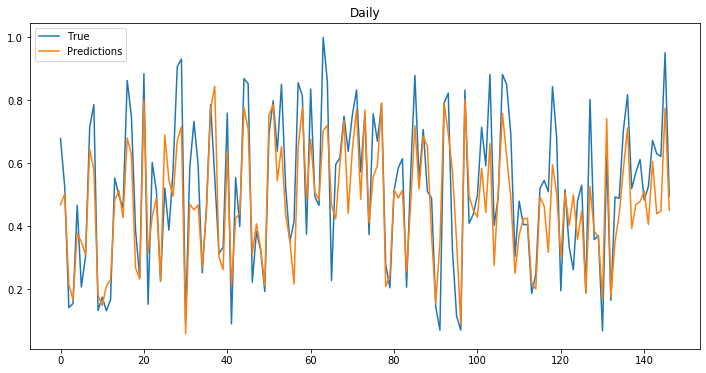

In [52]:
plt.figure(figsize = (12,6))
plt.plot(days, label = "True")
plt.plot(y_pred, label = "Predictions")
plt.title('Daily')
plt.legend()
plt.show()

In [51]:
print('The mean squared error is %.3f' % model.evaluate(dailyX_test, dailyy_test)[1])

147/147 [==============================] - 0s 61us/step
The mean squared error is 0.007


## Hourly Data Set

In [4]:
hourlyData = pd.read_csv('C:/Users/Jenny/Desktop/UOP-MSDS/2020Spring/ANLT_210_SoftwareMethods/Bikeshare/Data/hourly.csv')

Same as in the EDA phase, we will remove features that aren't needed and repeative.

In [5]:
hourlyData2 = hourlyData.drop(['instant', 'dteday', 'hr', 'casual', 'registered'], axis = 1)

### Cleanning the Data Set
Getting dummy variables for categorical features using the *cleaningData* function above.

In [6]:
hourlyCate = cleaningData(hourlyData2)

In [7]:
hourlyCate.head()

,temp,atemp,hum,windspeed,season_1,season_2,season_3,season_4,yr_0,yr_1,...,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4,cnt
0,0.24,0.2879,0.81,0.0,1,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,16
1,0.22,0.2727,0.80,0.0,1,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,40
2,0.22,0.2727,0.80,0.0,1,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,32
3,0.24,0.2879,0.75,0.0,1,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,13
4,0.24,0.2879,0.75,0.0,1,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,1


In [8]:
hourlyCate.shape

(17379, 38)

### Feature selection

Selecting top n features with ExtraTreesClassifier and the *featureSelect* function created above

In [9]:
xFeath, yh = featureSelect(hourlyCate, 10)

In [10]:
xFeath.head()

,hum,windspeed,atemp,temp,weathersit_1,weathersit_3,weekday_5,weathersit_2,yr_0,weekday_3
0,0.81,0.0,0.2879,0.24,1,0,0,0,1,0
1,0.80,0.0,0.2727,0.22,1,0,0,0,1,0
2,0.80,0.0,0.2727,0.22,1,0,0,0,1,0
3,0.75,0.0,0.2879,0.24,1,0,0,0,1,0
4,0.75,0.0,0.2879,0.24,1,0,0,0,1,0


### Split and normalize the data
The data set is normalized using StandardScaler from sklearns. The split will be 80% for train and 20% for test.

In [12]:
dfh = pd.concat([xFeath, yh], axis = 1)

In [13]:
# normalize
sc = MinMaxScaler(feature_range=(0, 1))
dfh2 = pd.DataFrame(sc.fit_transform(dfh))
dfh2.columns = dfh.columns

In [14]:
dfhX = dfh2.drop(['cnt'], axis = 1)
dfhy = dfh2['cnt']

In [15]:
hourlyX_train, hourlyX_test, hourlyy_train, hourlyy_test = train_test_split(dfhX, dfhy, test_size = 0.2, random_state = 0)

### Deep NN

In [17]:
model = Sequential()
model.add(Dense(100, activation = 'relu', input_dim = hourlyX_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))

#print summary
model.summary()

# loss funtcion
model.compile(loss = 'mean_squared_error',
              optimizer = 'RMSprop',
              metrics = ['accuracy', 'mse'])

# fit the model
model.fit(hourlyX_train,
          hourlyy_train,
          batch_size = 100,
          epochs = 50,
          validation_split = 1/6,
          verbose = 1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,201
Trainable params: 6,201
Non-trainable params: 0
_________________________________________________________________
Train on 11585 samples, validate on 2318 samples
Epoch 1/50
11585/11585 [==============================] - 1s 117us/st

11585/11585 [==============================] - 0s 38us/step - loss: 0.0228 - accuracy: 0.0082 - mse: 0.0228 - val_loss: 0.0216 - val_accuracy: 0.0078 - val_mse: 0.0216
Epoch 41/50
11585/11585 [==============================] - 1s 45us/step - loss: 0.0226 - accuracy: 0.0082 - mse: 0.0226 - val_loss: 0.0224 - val_accuracy: 0.0078 - val_mse: 0.0224
Epoch 42/50
11585/11585 [==============================] - 0s 40us/step - loss: 0.0225 - accuracy: 0.0082 - mse: 0.0225 - val_loss: 0.0218 - val_accuracy: 0.0078 - val_mse: 0.0218
Epoch 43/50
11585/11585 [==============================] - 0s 37us/step - loss: 0.0227 - accuracy: 0.0082 - mse: 0.0227 - val_loss: 0.0220 - val_accuracy: 0.0078 - val_mse: 0.0220
Epoch 44/50
11585/11585 [==============================] - 0s 38us/step - loss: 0.0226 - accuracy: 0.0082 - mse: 0.0226 - val_loss: 0.0219 - val_accuracy: 0.0078 - val_mse: 0.0219
Epoch 45/50
11585/11585 [==============================] - 0s 37us/step - loss: 0.0227 - accuracy: 0.0082 - mse:

In [18]:
# predict 'cnt'
y_predh = model.predict(hourlyX_test)

### Plotting true values (y) and predictions (y_pred) for Hourly Data Set

In [19]:
hours = hourlyy_test.values

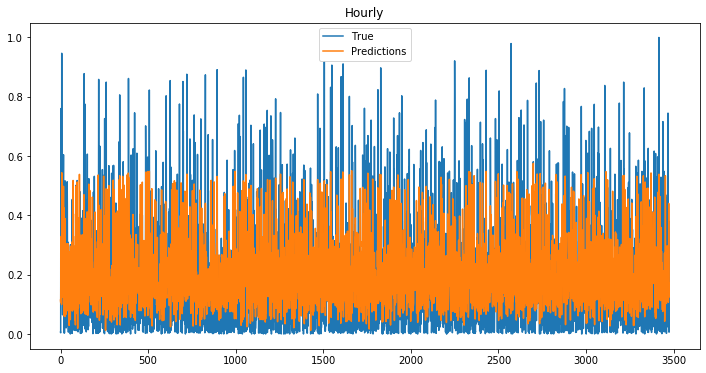

In [53]:
plt.figure(figsize = (12,6))
plt.plot(hours, label = "True")
plt.plot(y_predh, label = "Predictions")
plt.title('Hourly')
plt.legend()
plt.show()

In [21]:
print('The mean squared error is %.3f' % model.evaluate(hourlyX_test, hourlyy_test)[1])

3476/3476 [==============================] - 0s 32us/step
The mean squared error is 0.013
